# Applying Metamap to clinical text to extract UMLS concepts

In [1]:
import json
import csv
import os
import pandas as pd
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import dgl
from tqdm import tqdm_notebook as tqdm
import torch
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.data import Data, DataLoader
import pickle

In [2]:
#load in cui2vec, concepts_to_ids, concepts_to_strings, semtypes.csv, and SNOMEDCT_Graph.pkl
cui2vec_path = '/home/dc925/project/data/cui2vec/cui2vec_pretrained.csv'
cui2vec = pd.read_csv(cui2vec_path, index_col=0,header=0)
cui2vec_index = list(cui2vec.index)

concepts_to_ids = np.load('concepts_to_ids.json.npy').item()
ids_to_concepts = {i: cui for cui, i in concepts_to_ids.items()}
concepts_to_strings = np.load('concepts_to_strings.json.npy').item()
concepts_to_semtypes = pd.read_csv('semtypes.csv')
ids_to_concepts[777777] = 'F'
concepts_to_strings['F'] = 'FILLER'
snomed_graph = nx.read_gpickle('SNOMEDCT_Graph.pkl')

In [3]:
data_dir = '/home/dc925/project/data/seq_pair/MEDSTS/k_fold_4'

# Parsing metamap outputs

In [4]:
banned_concepts = ['C2004580', 'C1562890', 'C0052432', 'C0373548', 'C0178362', 'C0205108', 'C3541383', \
    'C0406636', 'C1439487', 'C0270724', 'C0015458', 'C0326374', 'C0011119', 'C0439851', \
    'C0700385', 'C0439267', 'C3645611', 'C0597295', 'C0002055', 'C0178499', 'C0439453', \
    'C0221262', 'C0007452', 'C3864032', 'C0016327', 'C0995147', 'C0310197', 'C0699900', \
    'C3542948', 'C1282485', 'C0444504', 'C0453946', 'C0178987', 'C0278005', 'C0031084', \
    'C0439070', 'C1556083', 'C3540738', 'C0004764', 'C0012621', 'C4319699', 'C0332521', \
    'C3888057', 'C3263723', 'C0453882', 'C0002111', 'C0002424', 'C0011892', 'C1849930', \
    'C2930619', 'C0439612', 'C1947971', 'C4708710', 'C4708711', 'C1608324', 'C0016382', \
    'C0021966', 'C0231290', 'C1704322', 'C0748355', 'C0313269', 'C0000768', 'C0181904', \
    'C0227665', 'C1704474', 'C1522613', 'C0263539', 'C0341618', 'C0429931', 'C0242414', \
    'C4048375', 'C0225407', 'C0278319', 'C1719822', 'C0080078', 'C1720467', 'C4321376', \
    'C0013119', 'C0183622', 'C0426862', 'C0013227', 'C4521676', 'C3879048', 'C0011682', \
    'C0012634', 'C0002930', 'C0444099', 'C0332461', 'C1707974', 'C0547043', 'C0347981', \
    'C0564385', 'C0439493', 'C0559739', 'C0017095', 'C0234861', 'C1439502', 'C0439228', \
    'C0152054', 'C0205246', 'C4521767', 'C0567305', 'C1282927', 'C0440102', 'C0439178', \
    'C4510119', 'C0324740', 'C0439189', 'C1292769', 'C0439645', 'C0009450', 'C0325736', \
    'C0006147', 'C0439835', 'C3839460', 'C0456564', 'C0030372', 'C0015231', 'C0439175', \
    'C0205136', 'C1279901', 'C0014007', 'C1439589', 'C1439600', 'C0312418', 'C0427965', \
    'C0272322', 'C0423899', 'C0183683', 'C0585288', 'C0702093', 'C1439688', 'C1856883', \
    'C0023175', 'C4553942', 'C0565930', 'C0424302', 'C1306345', 'C0199673', 'C0043309', \
    'C1962945', 'C0589079', 'C1705104', 'C3853114', 'C0586034', 'C0586037', 'C0439180', \
    'C0439631', 'C2363129', 'C0039409', 'C3872857', 'C1550678', 'C4082106', 'C0012002', \
    'C0311392', 'C1285400', 'C0586016', 'C0554950', 'C1561964', 'C1617072', 'C4282110', \
    'C4303120', 'C4303121', 'C4303122', 'C4303123', 'C1626935', 'C0332568', 'C1633989', \
    'C0332302', 'C3810365', 'C0013126', 'C1947944', 'C0150641', 'C0311392', 'C0991510', \
    'C0455909', 'C0456079', 'C3266262', 'C0358003', 'C0690620', 'C0690625', 'C1387403', \
    'C0556581', 'C0021359', 'C4522128', 'C0449450', 'C0037179', 'C2746065', 'C0441478', \
    'C0419193', 'C0557651', 'C2724208', 'C2724205', 'C0442724', 'C0442723', 'C0442722', \
    'C0559740', 'C0086287', 'C0441923', 'C3650253', 'C3650255', 'C0018818', 'C4318427', \
    'C3888058', 'C0449913', 'C0029237', 'C1995000', 'C0460009', 'C1275670', 'C0344311', \
    'C1533810', 'C1704765', 'C1442877', 'C0521850', 'C0150312', 'C1260956', 'C0015576', \
    'C0332166', 'C0332996', 'C0205393', 'C0443302', 'C0335350', 'C1963578', 'C1705211', \
    'C0585289', 'C0205160', 'C0422768', 'C0001554', 'C3839141', 'C3489575', 'C4319628', \
    'C3873840', 'C4521689', 'C3541994', 'C1705810', 'C4708903', 'C1283071', 'C1300901', \
    'C0443225', 'C3872897', 'C4319658', 'C1948053', 'C1533128', 'C1305400', 'C0445403', \
    'C1547383', 'C0079504', 'C0021272', 'C1278528', 'C0438971', 'C0319308', 'C4521054', \
    'C1285542', 'C1257890', 'C0687744', 'C0042815', 'C3536884', 'C0041159', 'C0183804', \
    'C1319883', 'C2362543', 'C0449719', 'C0309872', 'C0015671', 'C0262578', 'C0224415', \
    'C0224416', 'C0230463', 'C1320644', 'C1971630', 'C0554991', 'C0007457', 'C0043157', \
    'C0745977', 'C0495958', 'C0423653', 'C0542475', 'C0566415', 'C1883720', 'C0475824', \
    'C1705116', 'C0857246', 'C0278189', 'C2959938', 'C1608430', 'C4551656', 'C1293152', \
    'C0301630', 'C1997894', 'C1533734', 'C1283828', 'C0919758', 'C1519795', 'C3540037', \
    'C4284008', 'C3874352', 'C2314981', 'C1276418', 'C1276416', 'C1282918', 'C0040457', \
    'C0017463', 'C1522196', 'C0204977', 'C0205397', 'C1706249', 'C1293134', 'C0743223', \
    'C0230069', 'C1293636', 'C0194804', 'C0439787', 'C0449580', 'C0278286', 'C0439775', \
    'C3266231', 'C0702240', 'C1515187', 'C4521681', 'C0230445', 'C3715212', 'C0205458', \
    'C0423703', 'C0332571', 'C0224548', 'C1290685', 'C0202368', 'C3873153', 'C0524170', \
    'C0599910', 'C0542538', 'C3812897', 'C4048181', 'C3665593', 'C0919414', 'C1705114', \
    'C0028677', 'C0205172', 'C4082120', 'C0016249', 'C1644714', 'C4082117', 'C1515258', \
    'C0566875', 'C1278517', 'C0014518', 'C0030858', 'C1304890', 'C0013987', 'C1522168', \
    'C1272684', 'C3662690', 'C4082138', 'C0037709', 'C0033095', 'C0205289', 'C0560801', \
    'C2945599', 'C0684312', 'C0404118', 'C2939148', 'C0425560', 'C3853111', 'C0541747', \
    'C0392768', 'C0557043', 'C0439539', 'C0423153', 'C0439531', 'C0332271', 'C0699718', \
    'C3887611', 'C0588446', 'C0027361', 'C1282910', 'C0036974', 'C4522268', 'C0343755', \
    'C0019699', 'C0449435', 'C1399735', 'C2711067', 'C2711518', 'C2919432', 'C1272695', \
    'C0040461', 'C0334915', 'C0337625', 'C0337624', 'C0007294', 'C0021485', 'C0439148', \
    'C3831015', 'C0205394', 'C0205117', 'C4551147', 'C4551148', 'C0430400', 'C2242979', \
    'C1571999', 'C4521936', 'C1299361', 'C0812225', 'C3669643', 'C0175636', 'C4544460', \
    'C4521688', 'C1439500', 'C0001246', 'C1272460', 'C0234051', 'C3697854', 'C0424215', \
    'C0442725', 'C2724207', 'C0582153', 'C0460137', 'C2939459', 'C3542952', 'C0684224', \
    'C0566256', 'C4319630', 'C3874456', 'C0556987', 'C0264272', 'C1638312', 'C0521995', \
    'C0521996', 'C0418911', 'C0441987', 'C0338724', 'C0347984', 'C0024440', 'C0205451', \
    'C0149960', 'C0034072', 'C0421180', 'C0150369', 'C0009791', 'C0037297', 'C0581766', \
    'C0442824', 'C1291764', 'C4083049', 'C0205219', 'C0549447', 'C1456348', 'C0420329', \
    'C0420330', 'C1382107', 'C1705537', 'C0812378', 'C0564233', 'C4274567', 'C4319771', \
    'C0227544', 'C4039542', 'C1306847', 'C0566256', 'C0449432', 'C0522501', 'C1306462', \
    'C1706486', 'C4521686', 'C0423896', 'C0428210', 'C0184752', 'C1382110', 'C1317949', \
    'C3245462', 'C1442452', 'C3714811', 'C2732413', 'C0423730', 'C4553624', 'C0424805', \
    'C0686977', 'C0332153', 'C0018534', 'C1720725', 'C0392360', 'C0332490', 'C3714496', \
    'C0232269', 'C4511920', 'C0563287', 'C4706484', 'C0439166', 'C0577841', 'C0202406', \
    'C0240859', 'C4319718', 'C4520890', 'C1285961', 'C4551342', 'C0150220', 'C4552032', \
    'C2732410', 'C0455609', 'C0034519', 'C1276784', 'C0677453', 'C0558302', 'C4521982', \
    'C4512002', 'C1705223', 'C3864080', 'C4551290', 'C0425442', 'C0518227', 'C0425470', \
    'C4706354', 'C0422830', 'C0600083', 'C0444185', 'C0599973', 'C0029408', 'C0456616', \
    'C0332206', 'C0225408', 'C0423797', 'C1704353', 'C0444611', 'C0303753', 'C3494708', \
    'C1282913', 'C0423102', 'C2700446', 'C1637837', 'C3880167', 'C3203520', 'C0018378', \
    'C3839032', 'C0434982', 'C0424853', 'C0581847', 'C0582921', 'C0009264', 'C0410234', \
    'C4318619', 'C0352321', 'C4544674', 'C3532489', 'C0420221', 'C0005680', 'C0027567', \
    'C0085756', 'C0175703', 'C1276425', 'C1720092', 'C1302301', 'C0423798', 'C1096155', \
    'C0577573', 'C1306372', 'C4274976', 'C1443917', 'C0439167', 'C0332177', 'C1267117', \
    'C0037913', 'C0441994', 'C0206736', 'C0000912', 'C1266878', 'C0332307', 'C0392905', \
    'C1318569', 'C1446388', 'C0445247', 'C4082130', 'C3873778', 'C0332149', 'C0070939', \
    'C0009647', 'C0204922', 'C0991553', 'C0006086', 'C0013879', 'C1562651', 'C1305285', \
    'C4274169', 'C0340770', 'C0700221', 'C0420738', 'C4284072', 'C0497156', 'C0198018', \
    'C4048282', 'C0574161', 'C4040273', 'C4039745', 'C1276414', 'C0268238', 'C0587621', \
    'C4318415', 'C0447584', 'C0457933', 'C1293030', 'C1719952', 'C3845843', 'C0442015', \
    'C0441597', 'C3697008', 'C4521772', 'C0685682', 'C0332296', 'C0444799', 'C0700614', \
    'C0702194', 'C0190802', 'C3661652', 'C0452333', 'C4038931', 'C0204324', 'C0234001', \
    'C0016410', 'C0502420', 'C0436315', 'C0586409', 'C0457176', 'C0729362', 'C0370003', \
    'C0578454', 'C0017596', 'C0184348', 'C4274918', 'C4304123', 'C0547047', 'C0442805', \
    'C0336911', 'C0444667', 'C0566646', 'C0439230', 'C0226896', 'C4082119', 'C0559474', \
    'C0456761', 'C0439659', 'C0917805', 'C0009967', 'C0204506', 'C0542341', 'C1301793', \
    'C1301805', 'C1301923', 'C1283233', 'C0205179', 'C0729895', 'C0521592', 'C0004916', \
    'C1533092', 'C0393865', 'C0175671', 'C1274039', 'C2004491', 'C0577844', 'C0332282', \
    'C0225756', 'C0225758', 'C0026649', 'C0205163', 'C2939193', 'C0332283', 'C1112870', \
    'C0004048', 'C1279889', 'C0700231', 'C0332837', 'C1705604', 'C2828363', 'C4319676', \
    'C4520563', 'C0011167', 'C0445223', 'C0439849', 'C0332196', 'C0205449', 'C0205448', \
    'C0234126', 'C0205452', 'C4082118', 'C0205485', 'C0849912', 'C0224086', 'C0023226', \
    'C0281867', 'C0571105', 'C1314939', 'C0204650', 'C0205250', 'C0205146', 'C0332287', \
    'C0700364', 'C0205229', 'C0678211', 'C0271466', 'C1535502', 'C2587213', 'C0425152', \
    'C0043227', 'C1516050', 'C0205197', 'C0557854', 'C0332257', 'C1444656', 'C0205540', \
    'C0439505', 'C0086409', 'C3161473', 'C0025663', 'C0456387', 'C0175674', 'C1301625', \
    'C0600138', 'C4518185', 'C0205447', 'C1527305', 'C0040223', 'C0205132', 'C0332849', \
    'C0205396', 'C0205225', 'C1303145', 'C0392747', 'C0439673', 'C2745955', 'C0205314', \
    'C1265611', 'C0576978', 'C0700321', 'C0750729', 'C0333118', 'C0444930', 'C0560560', \
    'C0302143', 'C0262950', 'C0205450', 'C0237753', 'C2362652', 'C0443289', 'C0422980', \
    'C1287591', 'C1287592', 'C0348011', 'C0332156', 'C0231199', 'C0750491', 'C0205382', \
    'C0457083', 'C0224334', 'C0205391', 'C0700374', 'C0231918', 'C0234192', 'C0150934', \
    'C1442065', 'C1273517', 'C0457385', 'C1455667', 'C0340668', 'C0274281', 'C0459302', \
    'C0868928', 'C0455219', 'C0027552', 'C0443211', 'C4707055', 'C1827465', 'C0373817', \
    'C0332464', 'C0332185', 'C0333056', 'C0205358', 'C0233494', 'C4318471', 'C0458850', \
    'C0241635', 'C0205379', 'C0205309', 'C0347997', 'C0040300', 'C0391871', 'C0004927', \
    'C0884358', 'C0418624', 'C0449468', 'C1690016', 'C0086045', 'C0332281', 'C2963144', \
    'C1301820', 'C0206244', 'C3536832', 'C0001861', 'C1300196', 'C0033414', 'C0014653', \
    'C0179199', 'C0205177', 'C0439801', 'C0237401', 'C0441889', 'C1704243', 'C0205435', \
    'C1292711', 'C0549178', 'C1313868', 'C0392756', 'C0443131', 'C0205245', 'C0442799', \
    'C0442797', 'C0442821', 'C0231481', 'C2986650', 'C0009566', 'C0439534', 'C0449820', \
    'C1280500', 'C0686907', 'C0449911', 'C0700287', 'C0205453', 'C0039224', 'C0456378', \
    'C0332152', 'C0740175', 'C0589496', 'C0205307', 'C0332285', 'C0332157', 'C0542399', \
    'C0025105', 'C1704458', 'C0017466', 'C0733755', 'C1319136', 'C0224794', 'C0439204', \
    'C0439810', 'C0562325', 'C0439603', 'C0205166', 'C1272706', 'C0585361', 'C0556984', \
    'C1275532', 'C1275533', 'C0427068', 'C0575810', 'C0700042', 'C4319657', 'C0020548', \
    'C0439844', 'C0205251', 'C4319838', 'C0175627', 'C0420251', 'C4281029', 'C1960278', \
    'C0027442', 'C0020258', 'C3472347', 'C0013220', 'C0020963', 'C0231197', 'C0204008', \
    'C0557696', 'C0206428', 'C0556636', 'C0221023', 'C0558269', 'C1301759', 'C0027646', \
    'C1997188', 'C0430533', 'C4316545', 'C1292734', 'C0205123', 'C0520510', 'C0449286', \
    'C0006856', 'C0184741', 'C0205107', 'C0332272', 'C0521643', 'C4708569', 'C0205173', \
    'C0000924', 'C0585347', 'C0449444', 'C4521986', 'C1546956', 'C0175566', 'C0439508', \
    'C0424556', 'C0567230', 'C0344211', 'C1522240', 'C1272689', 'C4319659', 'C0522531', \
    'C2733455', 'C0037817', 'C4303528', 'C0518061', 'C1266786', 'C0429475', 'C0205170', \
    'C1442163', 'C0184532', 'C0011065', 'C1546956', 'C0033727', 'C0441932', 'C0011317', \
    'C1265875', 'C0205944', 'C1444479', 'C1705370', 'C0332232', 'C0233426', 'C0120446', \
    'C0596019', 'C4709312', 'C0205313', 'C0587588', 'C0449249', 'C0425569', 'C1455761', \
    'C1571702', 'C0183089', 'C0348025', 'C2734539', 'C0449788', 'C0600091', 'C4521969', \
    'C0460148', 'C0039738', 'C0441471', 'C1145759', 'C0337076', 'C1276348', 'C0265388', \
    'C0314620', 'C0042571', 'C0575164', 'C1691010', 'C0446817', 'C0580836', 'C0023882', \
    'C0338596', 'C0332167', 'C0682323', 'C0152057', 'C4040351', 'C1279752', 'C0516382', \
    'C0587625', 'C0199168', 'C0450043', 'C0229965', 'C0683369', 'C0032782', 'C0429986', \
    'C0439064', 'C0475091', 'C0023031', 'C0023749', 'C0337174', 'C0595998', 'C0020580']


# banned_concepts = []
semtype_map = {}
with open('SemanticTypes_2018AB.txt', 'r') as f:
    reader = csv.reader(f, delimiter="|")
    for line in reader:
        semtype_map[line[0]] = line[2]

def parse_metamap_output_filtered(metamap_output):
    with open(metamap_output, 'r') as f:
        data = json.load(f)
        documents = data['AllDocuments']
    concept_mappings = []
    for document in documents:
        phrases = document['Document']['Utterances'][0]['Phrases']
        document_mappings = []
        for phrase in phrases:
            phrasetext = phrase['PhraseText']
            phrase_mappings = []
            if len(phrase['Mappings']) != 0:
                for mapping in phrase['Mappings']:
                    for candidate in mapping['MappingCandidates']:
                        cui = candidate['CandidateCUI']
                        if cui not in banned_concepts:
                            preferred = candidate['CandidatePreferred']
                            if 'insulin' in preferred.lower():
                                preferred = 'insulin'
                                cui = "C0021641"
                            if 'carcinoma' in preferred.lower():
                                preferred = 'carcinoma'
                                cui = "C0007097"
                            if 'skin' in preferred.lower():
                                preferred = 'skin structure'
                                cui = 'C1123023'
                            if 'nicotine' in preferred.lower():
                                preferred = 'Nicotine'
                                cui = 'C0028040'
                            if 'hospital' in preferred.lower():
                                preferred = 'primary care hospital'
                                cui = 'C0337952'
                            if 'tretinoin' in preferred.lower():
                                preferred = 'tretinoin'
                                cui = 'C0040845'
                            if 'lives with' in preferred.lower():
                                preferred = 'lives with family'
                                cui = 'C0557130'
                            if 'right' in preferred.lower():
                                preferred = 'right'
                                cui = 'C0205090'
                            if 'left' in preferred.lower():
                                preferred = 'left'
                                cui = 'C0205091'
                            if 'sudden onset' in preferred.lower():
                                preferred = 'sudden onset'
                                cui = 'C1276802'
                            if 'plan' in preferred.lower():
                                preferred = 'care plan'
                                cui = 'C0178916'
                            if 'scale' in preferred.lower():
                                preferred = 'assessment scale'
                                cui = 'C0450973'
                            if 'schedule' in preferred.lower():
                                preferred = 'scheduling'
                                cui = 'C1446911'
                            if 'test' in preferred.lower():
                                preferred = 'test result'
                                cui = 'C0456984'
                            if 'malignant neoplasm' in preferred.lower():
                                preferred = 'malignant neoplasm'
                                cui = 'C0006826'
                            if 'finding' in preferred.lower():
                                preferred = 'finding'
                                cui = 'C0243095'
                            if 'discharge' in preferred.lower() and 'vaginal' not in preferred.lower():
                                preferred = 'patient discharge'
                                cui = 'C0030685'
                            if 'parent' in preferred.lower():
                                preferred = 'parent'
                                cui = 'C0030551'
                            if 'vaginal fluid' in preferred.lower():
                                preferred = 'vaginal discharge'
                                cui = 'C0227791'
                            if 'sore' in preferred.lower():
                                preferred = 'sore'
                                cui = 'C0234233'
                            if 'vulva' in preferred.lower():
                                preferred = 'vulval structure'
                                cui = 'C0042993'
                            if 'history' in preferred.lower():
                                preferred = 'medical history'
                                cui = 'C0262926'
                            if 'ceftriaxone' in preferred.lower():
                                preferred = 'ceftriaxone'
                                cui = 'C0007561'
                            if 'balance' in preferred.lower():
                                preferred = 'ability to balance'
                                cui = 'C0560184'
                            if 'ketoconazole' in preferred.lower():
                                preferred = 'Ketoconazole'
                                cui = 'C0022625'
                            if 'cataract' in preferred.lower():
                                preferred = 'cataract'
                                cui = 'C0086543'
                            if 'swelling' in preferred.lower():
                                preferred = 'swelling'
                                cui = 'C0038999'
                            if 'lymphadenopathy' in preferred.lower():
                                preferred = 'Lymphadenopathy'
                                cui = 'C0497156'
                            if 'contact' in preferred.lower() and 'injury' not in preferred.lower():
                                preferred = 'contact with'
                                cui = 'C0332158'
                            if 'discussion' in preferred.lower():
                                preferred = 'discussion'
                                cui = 'C0557061'
                            if 'intervention' in preferred.lower():
                                preferred = 'intervention'
                                cui = 'C1273869'
                            if 'relaps' in preferred.lower():
                                preferred = 'relapse'
                                cui = 'C0035020'
                            if 'day' in preferred.lower():
                                preferred = 'daily'
                                cui = 'C0332173'
                            if 'palpitation' in preferred.lower():
                                preferred = 'palpitation'
                                cui = 'C0030252'
                            if 'erythromycin' in preferred.lower():
                                preferred = 'erythromycin'
                                cui = 'C0014806'
                            if 'assessment' in preferred.lower():
                                preferred = 'evaluation procedure'
                                cui = 'C1261322'
                            if 'ultraso' in preferred.lower():
                                preferred = 'ultrasound'
                                cui = 'C0041618'
                            if 'knee' in preferred.lower():
                                preferred = 'knee joint'
                                cui = 'C0022745'
                            if 'numbness' in preferred.lower() or 'numb' in preferred.lower():
                                preferred = 'numbness'
                                cui = 'C0028643'
                            if 'ovar' in preferred.lower():
                                preferred = 'ovary'
                                cui = 'C0029939'
                            if 'intramuscular' in preferred.lower():
                                preferred = 'intramuscular'
                                cui = 'C0442117'
                            if 'blood' in preferred.lower():
                                preferred = 'blood'
                                cui = 'C0005767'
                            if 'sodium chloride' in preferred.lower():
                                preferred = 'sodium chloride'
                                cui = 'C0037494'
                            if 'assist' in preferred.lower():
                                preferred = 'assisting'
                                cui = 'C0557034'
                            if 'ibuprofen' in preferred.lower():
                                preferred = 'ibuprofen'
                                cui = 'C0020740'
                            if 'feedback' in preferred.lower():
                                preferred ='biofeedback'
                                cui = 'C0005491'
                            if 'education' in preferred.lower():
                                preferred = 'patient education'
                                cui = 'C0030688'
                            if 'prophylactic' in preferred.lower() or 'prevent' in preferred.lower():
                                preferred = 'preventive'
                                cui = 'C1456501'
                            if 'ofloxacin' in preferred.lower():
                                preferred = 'ofloxacin'
                                cui = 'C0028902'
                            if 'fetus' in preferred.lower():
                                preferred = 'fetus'
                                cui = 'C0015965'
                            if 'blister' in preferred.lower():
                                preferred = 'blister'
                                cui = 'C0005758'
                            if 'gene' in preferred.lower():
                                preferred = 'gene'
                                cui = 'C0017337'
                            if 'acne' in preferred.lower():
                                preferred = 'acne'
                                cui = 'C0702166'
                            if 'mometasone' in preferred.lower():
                                preferred = 'mometasone'
                                cui = 'C0360564'
                            if 'impaired' in preferred.lower():
                                preferred = 'impaired'
                                cui = 'C0221099'
                            if 'chronic pain' in preferred.lower():
                                preferred = 'chronic pain'
                                cui = 'C0150055'
                   
                            semtypes = [semtype_map[candidate['SemTypes'][i]] for i in range(len(candidate['SemTypes']))]
                            in_cui2vec = cui in cui2vec.index
                            phrase_mappings.append({'cui': cui, 'preferred': preferred, 'semtypes': semtypes, 'in_cui2vec':in_cui2vec})
                document_mappings.append({'text': phrasetext, 'mapping': phrase_mappings})
        concept_mappings.append(document_mappings)
    assert len(concept_mappings) == len(documents)
    return concept_mappings

def get_mm_output_filtered(data_dir):
    train = os.path.join(data_dir, 'train_mm_output.txt')
    dev = os.path.join(data_dir, 'dev_mm_output.txt')
    train_output = parse_metamap_output_filtered(train)
    dev_output = parse_metamap_output_filtered(dev)
    return train_output, dev_output

def get_concepts(output):
    all_cuis = []
    pair_cuis = {}
    for i, document in enumerate(output):
        cuis = []
        for mapping in document:
            for m in mapping['mapping']:
                if m and m['cui'] not in cuis:
                    cuis.append(m['cui'])
        if i % 2 == 0:
            pair_cuis['cuis1'] = cuis
        else:
            pair_cuis['cuis2'] = cuis
            all_cuis.append(pair_cuis)
            pair_cuis = {}
    return all_cuis

In [5]:
train_filtered, dev_filtered = get_mm_output_filtered(data_dir)

In [939]:
l = list(snomed_graph.neighbors(concepts_to_ids['C0595998']))
[concepts_to_strings[ids_to_concepts[i]] for i in l if ids_to_concepts[i] in cui2vec.index][:10]
# [ids_to_concepts[i] for i in l if ids_to_concepts[i] in cui2vec.index][:10]

['Lives with family',
 'Lives with friends',
 'Lives alone',
 'Lives with roommate',
 'Lives with partner']

In [203]:
'C0040845' in cui2vec.index

True

In [6]:
train_filtered[2300]
train_filtered[2382]
# train_filtered[419]

#fix 'member of self-help group' 
#normalize injury
#normalize pain management
#therapy service

[{'text': 'neurologic',
  'mapping': [{'cui': 'C0205494',
    'preferred': 'Neurologic (qualifier value)',
    'semtypes': ['Qualitative Concept'],
    'in_cui2vec': True}]},
 {'text': 'no fainting blackouts seizures weakness paralysis tingling numbness tremors involuntary movements',
  'mapping': [{'cui': 'C0427086',
    'preferred': 'Involuntary Movements',
    'semtypes': ['Sign or Symptom'],
    'in_cui2vec': True},
   {'cui': 'C0028643',
    'preferred': 'numbness',
    'semtypes': ['Sign or Symptom'],
    'in_cui2vec': True},
   {'cui': 'C0030554',
    'preferred': 'Paresthesia',
    'semtypes': ['Disease or Syndrome'],
    'in_cui2vec': True},
   {'cui': 'C0036572',
    'preferred': 'Seizures',
    'semtypes': ['Sign or Symptom'],
    'in_cui2vec': True},
   {'cui': 'C0039070',
    'preferred': 'Syncope',
    'semtypes': ['Sign or Symptom'],
    'in_cui2vec': True},
   {'cui': 'C0040822',
    'preferred': 'Tremor',
    'semtypes': ['Sign or Symptom'],
    'in_cui2vec': True},
  

In [9]:

train_filtered_file = 'filtered_train.p'
dev_filtered_file = 'filtered_dev.p'
with open(os.path.join(data_dir, train_filtered_file), 'wb') as out:
    pickle.dump(train_filtered, out)
with open(os.path.join(data_dir, dev_filtered_file), 'wb') as out:
    pickle.dump(dev_filtered, out)

# Construct dataset

In [7]:
def generate_concept_graphs(pair_cuis_list):
    #don't add artificial edge; keep them separate
    torch_graphs_a = []
    torch_graphs_b = []
    for pair_cuis in tqdm(pair_cuis_list, desc='Graphs'):
        cuis1 = pair_cuis['cuis1']
        cuis2 = pair_cuis['cuis2']
        cuis1 = get_final_cuis(cuis1)
        cuis2 = get_final_cuis(cuis2)
        graph1, nodes_mapping_1 = construct_graph(cuis1)
        graph2, nodes_mapping_2 = construct_graph(cuis2)
        
        #Make torch graph
        tg_g1 = dgl_to_tg(graph1)
        tg_g2 = dgl_to_tg(graph2)

        torch_graphs_a.append((tg_g1, nodes_mapping_1))
        torch_graphs_b.append((tg_g2, nodes_mapping_2))
        
    return torch_graphs_a, torch_graphs_b

def dgl_to_tg(dgl_g):
    h = dgl_g.ndata['h']
    g_nx = dgl_g.to_networkx()
    g_tg = from_networkx(g_nx)
    g_tg.x = h
    return g_tg

def construct_graph(cuis):
    if len(cuis) == 0:
        sg = nx.Graph()
        sg.add_node(777777)
        h = torch.randn([1,500], dtype=torch.float32)
        h = torch.zeros([1,500], dtype=torch.float32)
        
        #dgl stuff
        sg_dgl = dgl.DGLGraph()
        sg_dgl.add_nodes(1)
        sg_dgl.add_edges(sg_dgl.nodes(), sg_dgl.nodes())
        sg_dgl.ndata['h'] = h
        filler_node = sg_dgl.nodes()[-1]
        nodes_mapping = [(filler_node,777777)]
        return sg_dgl, nodes_mapping
    elif len(cuis) == 1:
        node_id = concepts_to_ids[cuis[0]]
        sg = snomed_graph.subgraph(node_id).copy()
        h = torch.from_numpy(cui2vec.loc[cuis[0]].values).view(1,500).float()
        
        #dgl stuff
        sg_dgl = dgl.DGLGraph()
        sg_dgl.from_networkx(sg)
        sg_dgl.add_edges(sg_dgl.nodes(), sg_dgl.nodes())
        sg_dgl.ndata['h'] = h
        filler_node = sg_dgl.nodes()[-1]
        nodes_mapping = [(filler_node, node_id)]
        return sg_dgl, nodes_mapping
    else:
        original_nodes = list(set([concepts_to_ids[c] for c in cuis]))
        subgraph_nodes = set(original_nodes)
        sg = snomed_graph.subgraph(subgraph_nodes).copy()
        i = 0
        added_edges = []
        while not nx.is_connected(sg):
            nodes = nx.shortest_path(snomed_graph, original_nodes[0], original_nodes[i])
            nodes_w_cui2vec = [n for n in nodes if ids_to_concepts[n] in cui2vec_index]
            for n in range(len(nodes_w_cui2vec)-1):
                edge = (nodes_w_cui2vec[n], nodes_w_cui2vec[n+1])
                if edge not in added_edges:
                    added_edges.append(edge)
            subgraph_nodes.update(nodes_w_cui2vec)
            sg = snomed_graph.subgraph(subgraph_nodes).copy()
            sg.add_edges_from(added_edges)
            i += 1
        sg_dgl = dgl.DGLGraph()
        sg_dgl.from_networkx(sg)
        nx_nodes = sorted(sg.nodes())
        nx_cuis = [ids_to_concepts[n] for n in nx_nodes]

        h = torch.from_numpy(cui2vec.loc[nx_cuis].values).float()
        
        #dgl stuff
        dgl_nodes = sg_dgl.nodes()
        sg_dgl.add_edges(sg_dgl.nodes(), sg_dgl.nodes())
        sg_dgl.ndata['h'] = h
        nodes_mapping = list(zip(dgl_nodes, nx_nodes))
        return sg_dgl, nodes_mapping
    

    
def get_final_cuis(cuis):
    cuis = [c for c in cuis if c in concepts_to_ids] #filter cuis not in graph
    no_cui2vec_indices = [i for i in range(len(cuis)) if cuis[i] not in cui2vec_index] #find idx of cuis without cui2vec
    for i in no_cui2vec_indices[::-1]: #reversed the list to not mess up order
        neighbors = list(snomed_graph.neighbors(concepts_to_ids[cuis.pop(i)])) #get neighbors of that cui
        neighbors = [i for i in neighbors if ids_to_concepts[i] not in banned_concepts] #filter out banned concepts
        neighbors_in_cui2vec = [ids_to_concepts[n] in cui2vec_index for n in neighbors] #whether those neighbors have cui2vec
        if True in neighbors_in_cui2vec:
            t = neighbors_in_cui2vec.index(True) #just pick the first neighbor that has a cui2vec
            new_cui = ids_to_concepts[neighbors[t]]
            cuis.append(new_cui) #add the replacement cui to list
        else:
            continue #basically, if even the neighbors dont have a cui2vec, it's probably not cool anyway
    return cuis

    


In [8]:
def get_labels(file_path):
    with open(file_path, 'r') as f:
        labels = []
        for line in f:
            example = json.loads(line)
            label = torch.tensor(example['label'], dtype=torch.float32).view(-1)
            label_c = torch.tensor(example['label_c'], dtype=torch.long).view(-1)
            label_type = torch.tensor(example['label_type'], dtype=torch.long).view(-1)
            pid = example['pid']
            labels.append({'label':label, 'label_c':label_c, 'label_type':label_type, 'pid':pid})
    return labels
## Get labels
def get_all_labels(data_dir):
    dev_file = os.path.join(data_dir, 'dev.jsonl')
    train_file = os.path.join(data_dir, 'train.jsonl')
    dev_labels = get_labels(dev_file)
    train_labels = get_labels(train_file)
    return dev_labels, train_labels

In [9]:
def construct_dataset(data_dir):
    train_output, dev_output = get_mm_output_filtered(data_dir)
    train_cuis, dev_cuis = get_concepts(train_output), get_concepts(dev_output)
    dev_graphs = generate_concept_graphs(dev_cuis)
    train_graphs = generate_concept_graphs(train_cuis)
    dev_graphs_a = dev_graphs[0]
    dev_graphs_b = dev_graphs[1]
    train_graphs_a = train_graphs[0]
    train_graphs_b = train_graphs[1]
    
    dev_labels, train_labels = get_all_labels(data_dir)
    dev_dataset_a = [Data(x=dev_graphs_a[i][0].x, edge_index=dev_graphs_a[i][0].edge_index, label=dev_labels[i]['label'], \
                          label_c=dev_labels[i]['label_c'], label_type=dev_labels[i]['label_type'], pid=dev_labels[i]['pid']) for i in range(len(dev_graphs_a))]
    dev_dataset_b = [Data(x=dev_graphs_b[i][0].x, edge_index=dev_graphs_b[i][0].edge_index, label=dev_labels[i]['label'], \
                          label_c=dev_labels[i]['label_c'], label_type=dev_labels[i]['label_type'], pid=dev_labels[i]['pid']) for i in range(len(dev_graphs_b))]
    train_dataset_a = [Data(x=train_graphs_a[i][0].x, edge_index=train_graphs_a[i][0].edge_index, label=train_labels[i]['label'], \
                           label_c=train_labels[i]['label_c'], label_type=train_labels[i]['label_type'], pid=train_labels[i]['pid']) for i in range(len(train_graphs_a))]
    train_dataset_b = [Data(x=train_graphs_b[i][0].x, edge_index=train_graphs_b[i][0].edge_index, label=train_labels[i]['label'], \
                           label_c=train_labels[i]['label_c'], label_type=train_labels[i]['label_type'], pid=train_labels[i]['pid']) for i in range(len(train_graphs_b))]

    train_nodes_mapping_a = [[ids_to_concepts[n] for n in list(zip(*train_graphs_a[i][1]))[1] if n!=777777] for i in range(len(train_graphs_a))]
    train_nodes_mapping_b = [[ids_to_concepts[n] for n in list(zip(*train_graphs_b[i][1]))[1] if n!=777777] for i in range(len(train_graphs_b))]
    dev_nodes_mapping_a = [[ids_to_concepts[n] for n in list(zip(*dev_graphs_a[i][1]))[1] if n!=777777] for i in range(len(dev_graphs_a))]
    dev_nodes_mapping_b = [[ids_to_concepts[n] for n in list(zip(*dev_graphs_b[i][1]))[1] if n!=777777] for i in range(len(dev_graphs_b))]
    return {'train_a':train_dataset_a, 'train_b':train_dataset_b, 'dev_a':dev_dataset_a, 'dev_b':dev_dataset_b, 'train_nodes_a':train_nodes_mapping_a, \
            'train_nodes_b':train_nodes_mapping_b, 'dev_nodes_a':dev_nodes_mapping_a, 'dev_nodes_b':dev_nodes_mapping_b}

In [436]:
data_dir

'/home/dc925/project/data/seq_pair/MEDSTS/k_fold_3'

In [437]:
bundle = construct_dataset(data_dir)

# Writing datasets

In [417]:
def write_datasets(data_dir, bundle):
    with open(os.path.join(data_dir, 'train_dataset_a.p'), 'wb') as out:
        pickle.dump(bundle['train_a'], out)
    with open(os.path.join(data_dir, 'train_dataset_b.p'), 'wb') as out:
        pickle.dump(bundle['train_b'], out)
    with open(os.path.join(data_dir, 'dev_dataset_a.p'), 'wb') as out:
        pickle.dump(bundle['dev_a'], out)
    with open(os.path.join(data_dir, 'dev_dataset_b.p'), 'wb') as out:
        pickle.dump(bundle['dev_b'], out)
    
    with open(os.path.join(data_dir, 'train_nodes_mapping_a.p'), 'wb') as out:
        pickle.dump(bundle['train_nodes_a'], out)
    with open(os.path.join(data_dir, 'train_nodes_mapping_b.p'), 'wb') as out:
        pickle.dump(bundle['train_nodes_b'], out)
    with open(os.path.join(data_dir, 'dev_nodes_mapping_a.p'), 'wb') as out:
        pickle.dump(bundle['dev_nodes_a'], out)
    with open(os.path.join(data_dir, 'dev_nodes_mapping_b.p'), 'wb') as out:
        pickle.dump(bundle['dev_nodes_b'], out)

In [438]:
write_datasets(data_dir, bundle)

# Graph visualization

In [209]:
#input graphs from dev_graphs and train_graphs a and b
def visualize_example(graph_a, graph_b, label):
    node_labels1 = {k.item(): concepts_to_strings[ids_to_concepts[v]] for k, v in graph_a[1]}
    node_labels2 = {k.item(): concepts_to_strings[ids_to_concepts[v]] for k, v in graph_b[1]}
    plt.figure(figsize=(10,7))
    nx.draw_kamada_kawai(to_networkx(graph_a[0]), with_labels=True, node_size=1000, labels=node_labels1, node_color='r', label='sentence a')
    print('n_nodes: {} \t n_edges: {}'.format(graph_a[0].num_nodes, graph_a[0].num_edges))
    plt.legend()
    plt.title('Sentence a', fontsize=20)
    plt.savefig('senta.png')
    plt.figure(figsize=(10,7))
    nx.draw_kamada_kawai(to_networkx(graph_b[0]), with_labels=True, node_size=1000, labels=node_labels2, label='sentence b')
    plt.legend()
    print('n_nodes: {} \t n_edges: {}'.format(graph_b[0].num_nodes, graph_b[0].num_edges))
    print('score: {}'.format(label))
# visualize_example(dev_graphs_a[8], dev_graphs_b[8], dev_labels[8]);

In [10]:
train_output, dev_output = get_mm_output_filtered(data_dir)
train_cuis, dev_cuis = get_concepts(train_output), get_concepts(dev_output)
dev_graphs = generate_concept_graphs(dev_cuis)
train_graphs = generate_concept_graphs(train_cuis)
dev_graphs_a = dev_graphs[0]
dev_graphs_b = dev_graphs[1]
train_graphs_a = train_graphs[0]
train_graphs_b = train_graphs[1]

In [13]:
dev_labels, train_labels = get_all_labels(data_dir)

In [ ]:
dev_data = []
with open(os.path.join(data_dir, 'dev.jsonl'), 'r') as f:
    for line in f:
        dev_data.append(json.loads(line))

In [204]:
n = 105

/ysm-gpfs/home/dc925/project/anaconda3/envs/dlnn/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/ysm-gpfs/home/dc925/project/anaconda3/envs/dlnn/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


n_nodes: 17 	 n_edges: 55
n_nodes: 18 	 n_edges: 58
score: {'label': tensor([4.7500]), 'label_c': tensor([2]), 'label_type': tensor([1]), 'pid': 994}


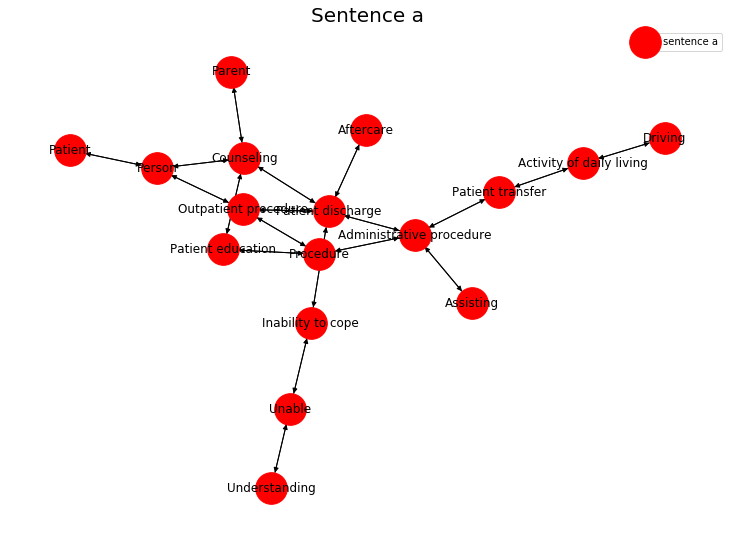

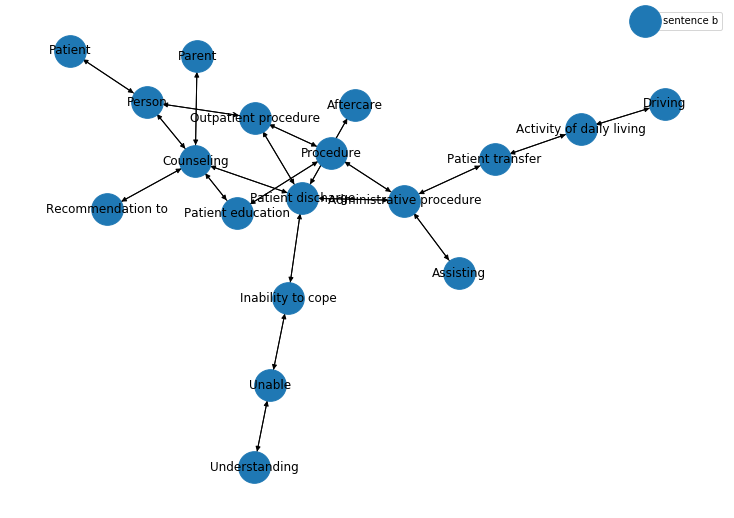

In [210]:
visualize_example(dev_graphs_a[n], dev_graphs_b[n], dev_labels[n])

In [206]:
dev_data[n]

{'sentence1': ' patient discharged to home  ambulating without assistance  family driving  accompanied by parent  above person s  verbalized understanding of discharge instructions and follow up care ',
 'sentence2': ' patient discharged to home  ambulating without assistance  family driving  accompanied by parent  discharge instructions given to patient  above person s  verbalized understanding of discharge instructions and follow up care ',
 'label': 4.75,
 'pid': 994,
 'label_c': 2,
 'label_c2': 1,
 'label_type': 1,
 'augment1': 'comprehension aftercare assisting automobile education',
 'augment2': 'comprehension aftercare assisting advised automobile education'}